In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import spc_os
from math import ceil
import theano.tensor as T
import scipy.stats as st

RANDOM_SEED = 28101990

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Fri Aug 06 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-147-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.4.2
pandas    : 1.3.0
pymc3     : 3.11.2
arviz     : 0.11.2
numpy     : 1.21.0
theano    : 1.1.2
scipy     : 1.7.0

Watermark: 2.2.0



In [3]:
raw_data_dir = "../data/raw/"
interim_data_dir = "../data/interim/"
processed_data_dir = "../data/processed/"
external_data_dir = "../data/external/"
models_dir = "../models/"

In [4]:
model_path = models_dir + "tpore_survival_analysis_individual_sim.nc"

In [5]:
infer = True
save_data = True
print(model_path)

../models/tpore_survival_analysis_individual_sim.nc


# Load data

In [6]:
df = pd.read_csv(f"{processed_data_dir}data.csv").drop("Unnamed: 0", axis=1)

In [7]:
df.Replica = df.Replica.astype("category")

In [8]:
df["Replica_enc"] = df.Replica.cat.codes

In [9]:
category_dic = {i: cat for i, cat in enumerate(np.unique(df["Replica"]))}

In [10]:
category_dic

{0: 'APM-hyp_1',
 1: 'APM-hyp_2',
 2: 'APM-hyp_3',
 3: 'APM-hyp_4',
 4: 'APM_1',
 5: 'APM_2',
 6: 'APM_3',
 7: 'APM_4',
 8: 'BPM-hyp_1',
 9: 'BPM-hyp_2',
 10: 'BPM-hyp_3',
 11: 'BPM-hyp_4',
 12: 'BPM_1',
 13: 'BPM_2',
 14: 'BPM_3',
 15: 'BPM_4'}

In [11]:
n_categories = len(category_dic)

In [12]:
dummies = pd.get_dummies(df.Replica, prefix="Replica")

In [13]:
for col in dummies.columns:
    df[col] = dummies[col]

In [14]:
df.tpore = df.tpore * 10
df.tpore = df.tpore.astype(int)

In [15]:
df.head()

,Replica,run,conf,frame,tpore,x0,y0,x1,y1,x2,...,Replica_APM_3,Replica_APM_4,Replica_BPM-hyp_1,Replica_BPM-hyp_2,Replica_BPM-hyp_3,Replica_BPM-hyp_4,Replica_BPM_1,Replica_BPM_2,Replica_BPM_3,Replica_BPM_4
0,APM-hyp_1,1,9,16,16,78,203,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,APM-hyp_1,2,9,15,15,68,130,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,APM-hyp_1,3,9,11,11,133,131,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,APM-hyp_1,4,9,10,10,199,114,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,APM-hyp_1,5,9,13,13,17,13,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Visualize Data

In [16]:
df["tpore"].groupby(df["Replica"]).describe()

,count,mean,std,min,25%,50%,75%,max
Replica,,,,,,,,
APM-hyp_1,60.0,16.983333,4.288304,7.0,14.00,16.0,19.25,31.0
APM-hyp_2,60.0,21.266667,6.979065,7.0,17.00,20.5,25.00,44.0
APM-hyp_3,60.0,23.183333,7.685539,10.0,16.75,22.5,28.00,43.0
APM-hyp_4,60.0,23.450000,8.203813,9.0,19.00,21.5,29.00,43.0
APM_1,60.0,27.066667,11.318002,11.0,19.00,25.0,33.00,60.0
APM_2,60.0,31.833333,14.873668,8.0,21.25,31.0,40.00,82.0
APM_3,60.0,40.566667,19.883872,13.0,26.50,37.0,49.50,107.0
APM_4,60.0,38.700000,18.285217,11.0,25.00,33.0,55.00,79.0
BPM-hyp_1,60.0,31.416667,11.621563,8.0,25.00,31.0,37.25,61.0


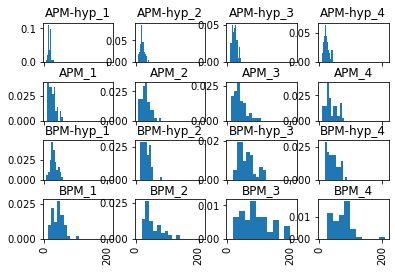

In [17]:
_ = df["tpore"].hist(by=df["Replica"], sharex=True, density=True, bins=10)

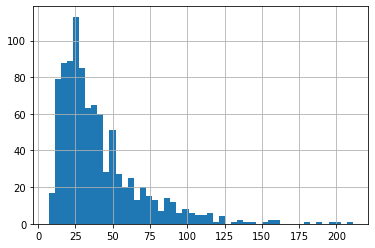

In [18]:
_ = df["tpore"].hist(bins=50)

## Visualize Priors

These are the shapes of the priors used.

Text(0.5, 0, 'lambda0(t)')

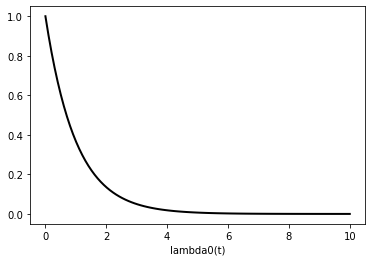

In [19]:
beta = 1
alpha = 1
d = st.gamma(scale=1 / beta, a=alpha)
x = np.linspace(0, 10, 100)
tau_0_pdf = d.pdf(x)
plt.plot(x, tau_0_pdf, "k-", lw=2)
plt.xlabel("lambda0(t)")

## Prepare data

In [20]:
n_sims = df.shape[0]
sims = np.arange(n_sims)
interval_length = 15  # 1.5 ns
interval_bounds = np.arange(0, df.tpore.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [21]:
last_period = np.floor((df.tpore - 0.01) / interval_length).astype(int)

pore = np.zeros((n_sims, n_intervals))
pore[sims, last_period] = np.ones(n_sims)

In [22]:
exposure = (
    np.greater_equal.outer(df.tpore.values, interval_bounds[:-1]) * interval_length
)
exposure[sims, last_period] = df.tpore - interval_bounds[last_period]

## Run Model

In [23]:
with pm.Model() as model:

    lambda0 = pm.Gamma("lambda0", 5, 1, shape=n_intervals)

    beta = pm.Normal("beta", 0, sigma=100, shape=(n_categories))

    lambda_ = pm.Deterministic(
        "lambda_", T.outer(T.exp(T.dot(beta, dummies.T)), lambda0)
    )
    mu = pm.Deterministic("mu", exposure * lambda_)
    exp_beta = pm.Deterministic("exp_beta", np.exp(beta))

    obs = pm.Poisson(
        "obs",
        mu,
        observed=pore,
    )

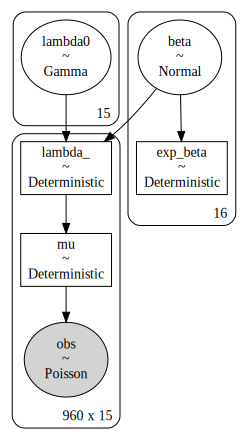

In [24]:
pm.model_to_graphviz(model)

In [25]:
%%time
if infer:
    with model:
        trace = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=True, cores=8)
else:
     trace=az.from_netcdf(model_path)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, lambda0]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 334 seconds.
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 1min 45s, sys: 2min 49s, total: 4min 35s
Wall time: 5min 49s


In [26]:
if infer:
    trace.posterior = trace.posterior.reset_index(
        ["beta_dim_0", "exp_beta_dim_0", "lambda0_dim_0"], drop=True
    )
    trace = trace.rename(
        {
            "lambda0_dim_0": "t",
            "beta_dim_0": "Membrane",
            "exp_beta_dim_0": "Membrane",
        }
    )
    trace = trace.assign_coords(
        t=interval_bounds[:-1] / 10,
        Membrane=list(category_dic.values()),
    )

## Posterior and prior predictive and 

In [27]:
%%time
if infer:
    with model:
        ppc = pm.sample_posterior_predictive(trace,  random_seed=RANDOM_SEED, samples=10000)
        print('Done infering.')
    trace = az.concat(trace, az.from_pymc3(posterior_predictive=ppc))

Done infering.


/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


CPU times: user 1min 36s, sys: 1min 31s, total: 3min 7s
Wall time: 28.5 s


In [28]:
%%time
# Prior predictive not important: uninformative priors
#if infer:
#    with model:
#        prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED, samples=1000)
#        trace.extend(az.from_pymc3(prior=prior))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


## Convergences

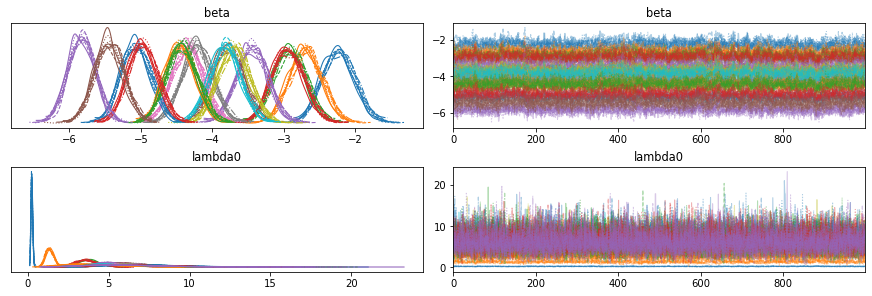

In [29]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_trace(trace, var_names=["beta", "lambda0"])

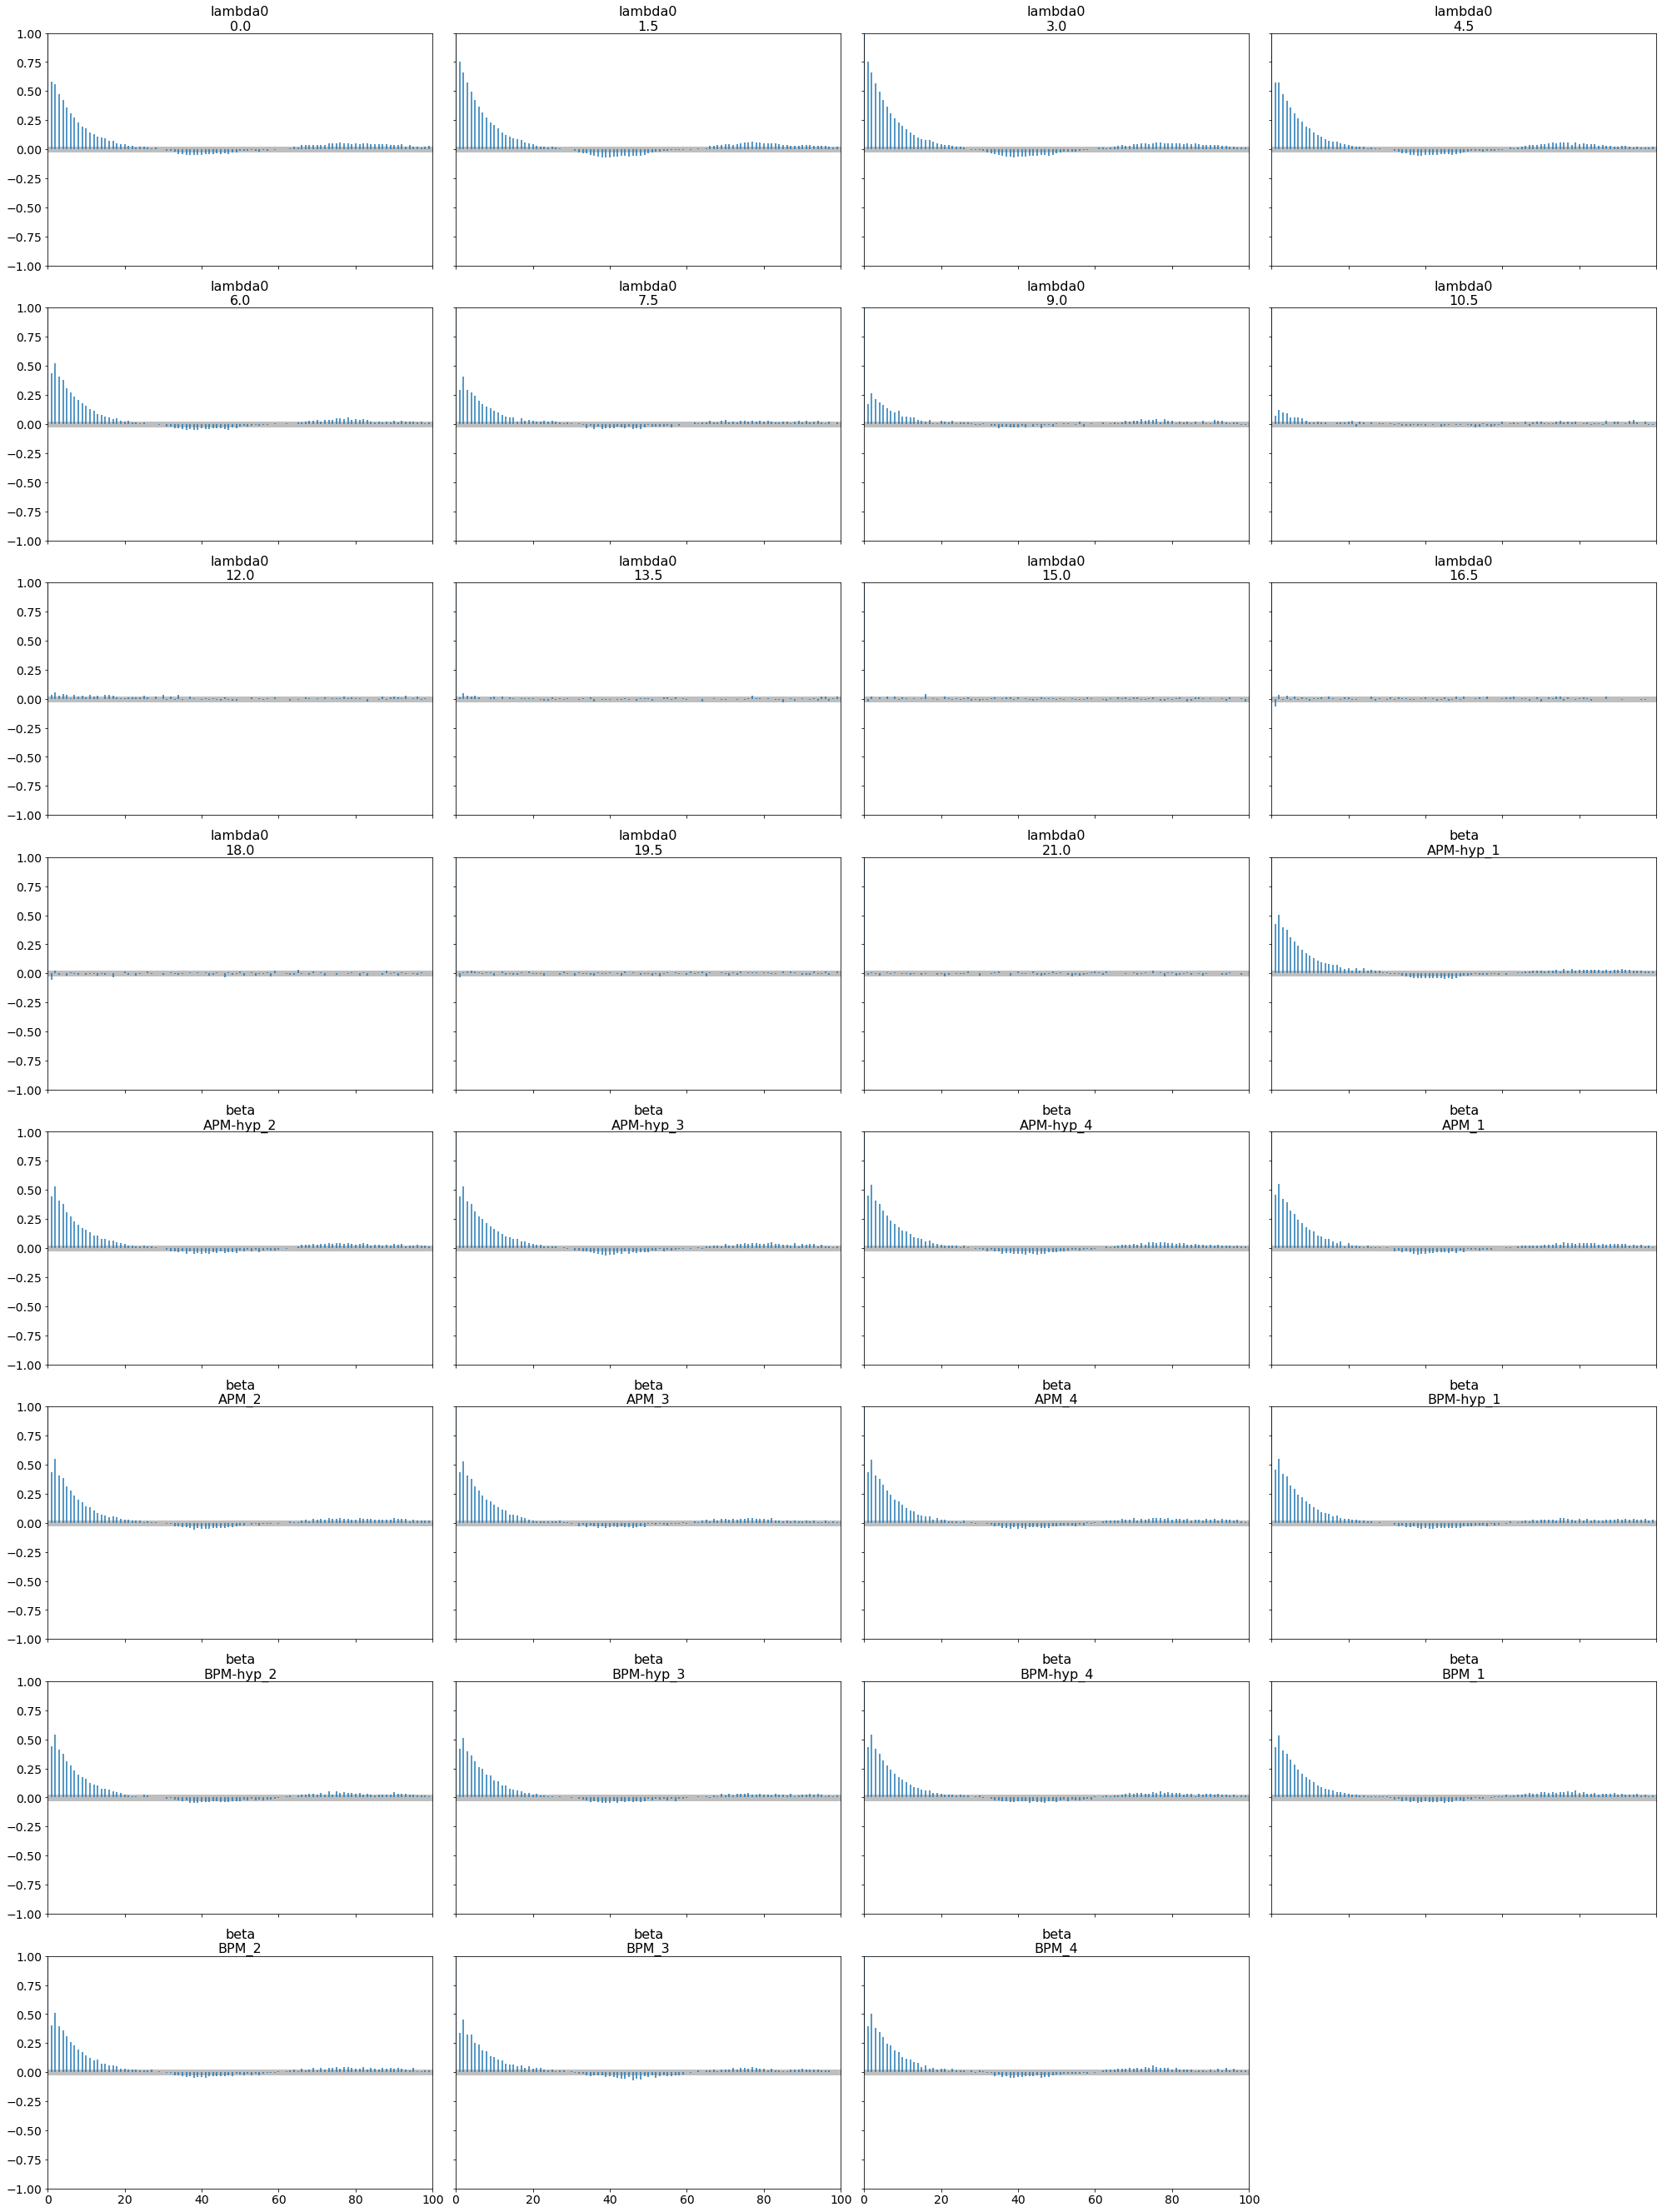

In [30]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_autocorr(trace, combined=True, var_names=["lambda0", "beta"])

In [31]:
def get_survival_function(trace):
    l = []
    for interval in range(n_intervals - 1):
        l.append(
            np.trapz(
                trace.values[:, :, :, 0 : interval + 1],
                axis=3,
                dx=interval_length,
            )
        )

    l = np.exp(-np.array(l))
    return l

In [32]:
def get_ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

In [33]:
def get_hdi(x, axis, alpha=0.06):
    x_mean = np.nanmedian(x, axis=axis)
    percentiles = 100 * np.array([alpha / 2.0, 1.0 - alpha / 2.0])
    hdi = np.nanpercentile(x, percentiles, axis=axis)

    return x_mean, hdi

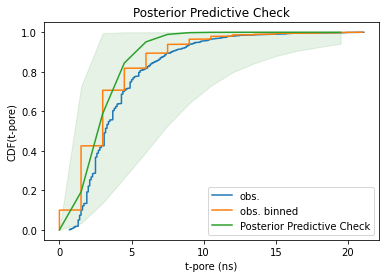

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

survival_function = get_survival_function(trace.posterior.lambda_)
# Empyrical CDF data
ax.plot(*get_ecdf(df.tpore / 10), label="obs.")

# Empyrical CDF data-binned
binned_data = np.where(pore[:, :] == 1)[1] * interval_length / 10
ax.plot(*get_ecdf(binned_data), label="obs. binned")

# Plot Posterior Predictive
hdi = get_hdi(survival_function[:, :, :, :], axis=(1, 2, 3))
x = np.arange(n_intervals - 1) * interval_length / 10.0
ax.plot(x, 1 - hdi[0], label="Posterior Predictive Check")
ax.fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color="g")
ax.set_xlabel("t-pore (ns)")
ax.set_ylabel("CDF(t-pore)")
ax.set_title("Posterior Predictive Check")
ax.legend()

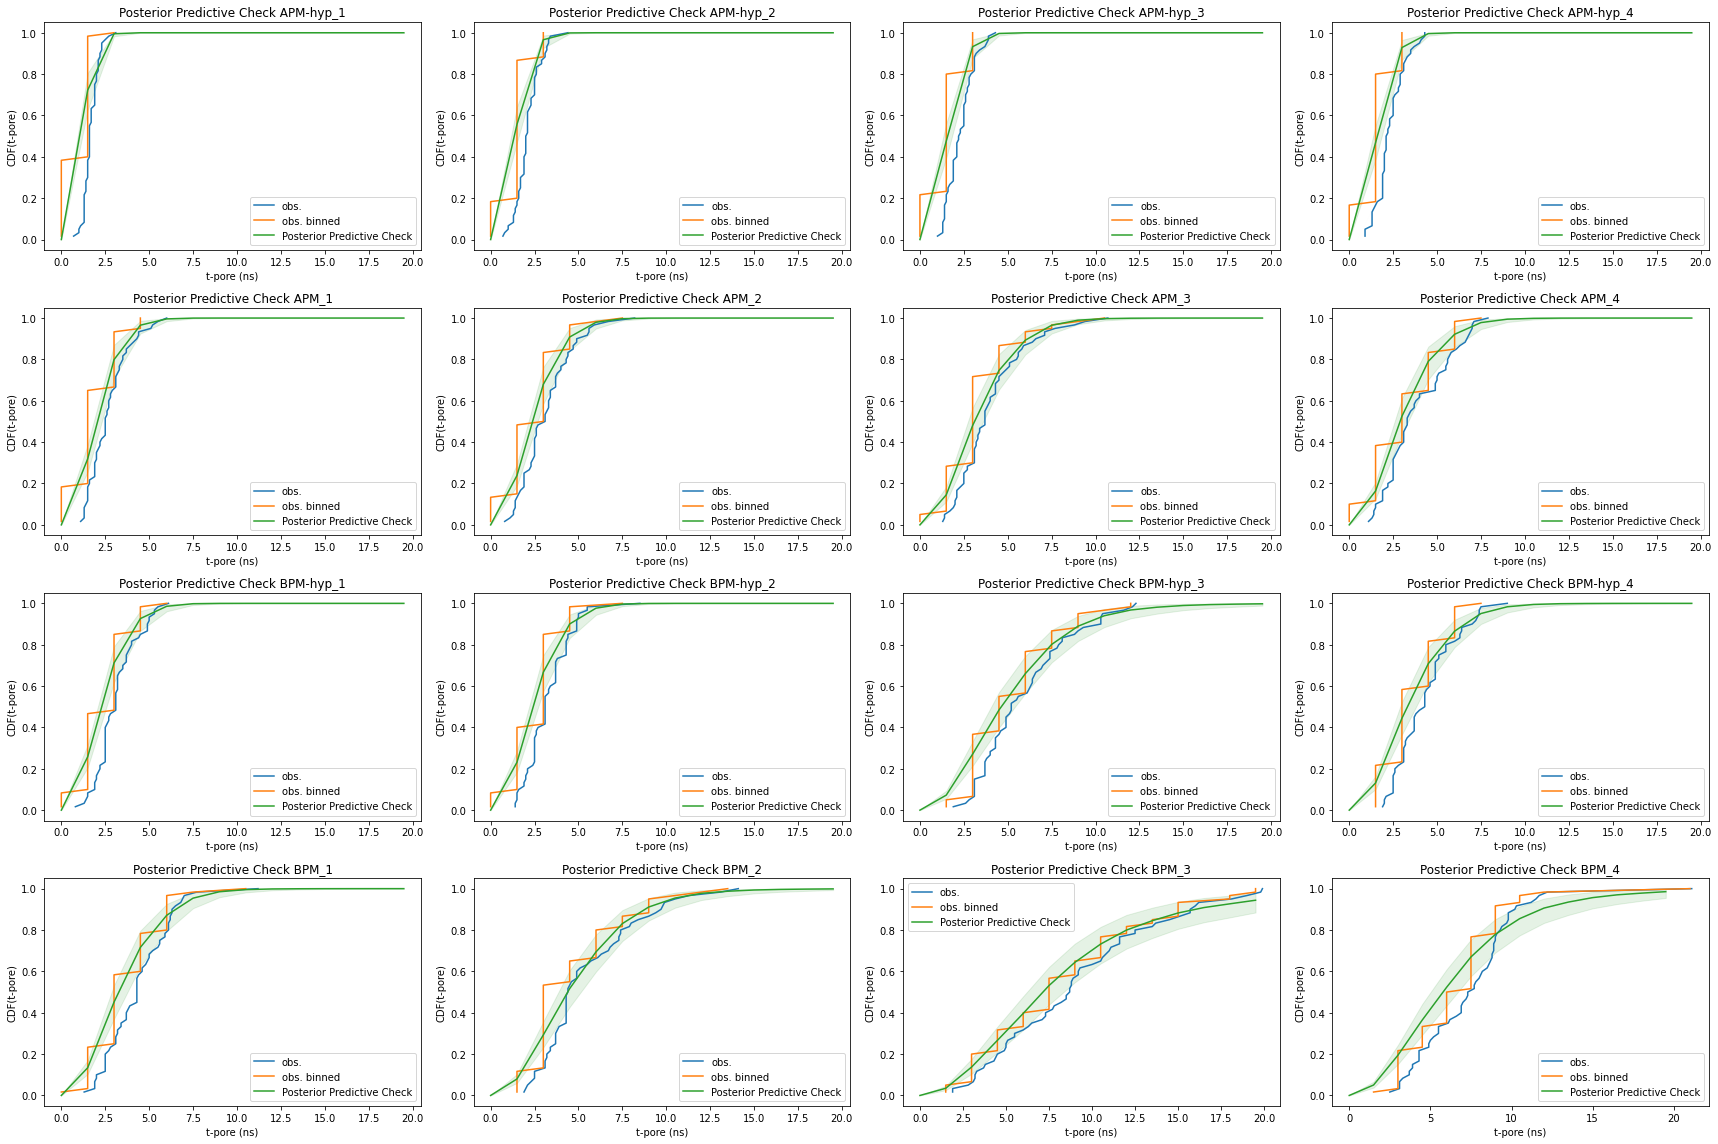

In [35]:
n_categories = len(category_dic)
n_rows = ceil(n_categories / 4)
fig, ax = plt.subplots(n_rows, 4, figsize=(6 * 4, 4 * n_rows))

ax = ax.flatten()
for i in range(n_categories):
    # Mask by replica type
    mask = df.Replica == category_dic[i]

    survival_function = get_survival_function(trace.posterior.lambda_[:, :, mask, :])
    # Empyrical CDF data
    ax[i].plot(*get_ecdf(df[mask].tpore / 10), label="obs.")

    # Empyrical CDF data-binned
    binned_data = np.where(pore[mask, :] == 1)[1] * interval_length / 10
    ax[i].plot(*get_ecdf(binned_data), label="obs. binned")

    # Plot Posterior Predictive
    hdi = get_hdi(survival_function[:, :, :, :], axis=(1, 2, 3))
    x = np.arange(n_intervals - 1) * interval_length / 10.0
    ax[i].plot(x, 1 - hdi[0], label="Posterior Predictive Check")
    ax[i].fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color="g")
    ax[i].set_xlabel("t-pore (ns)")
    ax[i].set_ylabel("CDF(t-pore)")
    ax[i].set_title(f"Posterior Predictive Check {category_dic[i]}")
    ax[i].legend()
fig.tight_layout()

## Analyze

### Plot posterior

Text(0.5, 0, 'lambda0[t]')

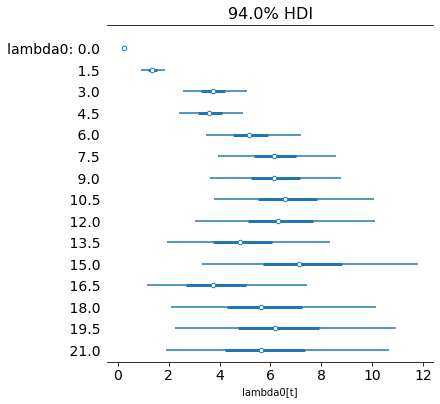

In [36]:
variable = "lambda0"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("lambda0[t]")

Text(0.5, 0, 'beta')

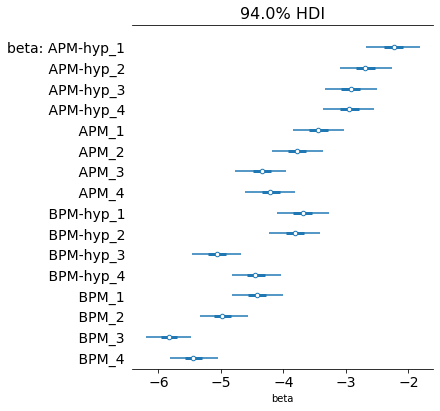

In [37]:
variable = "beta"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("beta")

Text(0.5, 0, 'exp(beta)')

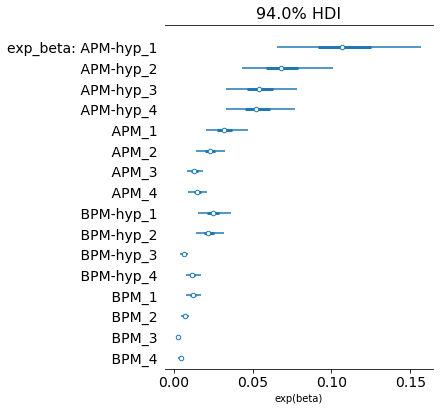

In [38]:
variable = "exp_beta"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("exp(beta)")

In [39]:
hdi = az.hdi(trace.posterior, var_names=["exp_beta"])
for i in range(n_categories):
    print(f"{category_dic[i]} {hdi.exp_beta[i,:].values.mean()}")

APM-hyp_1 0.11101976481788947
APM-hyp_2 0.07217911912170555
APM-hyp_3 0.055644505665293914
APM-hyp_4 0.054862610735127666
APM_1 0.033947246386345706
APM_2 0.023297322757879227
APM_3 0.013429032444982206
APM_4 0.015230357000204144
BPM-hyp_1 0.02598312415964699
BPM-hyp_2 0.02300288660432715
BPM-hyp_3 0.0065719591097406806
BPM-hyp_4 0.012315258182814029
BPM_1 0.01251864646068384
BPM_2 0.007282405467927348
BPM_3 0.003024098356526543
BPM_4 0.00448638950974008


Text(0.5, 0, 't (ns)')

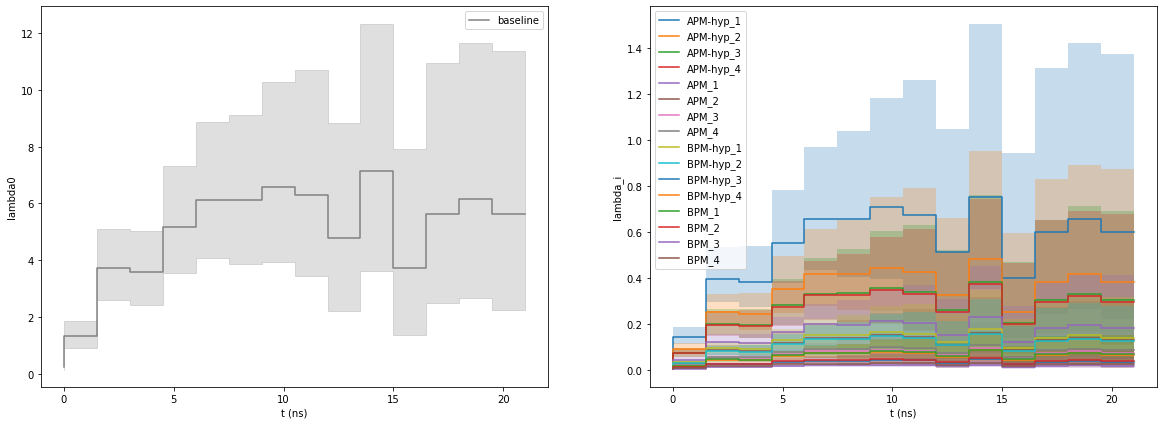

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
lambda0 = trace.posterior.lambda0.values
beta = trace.posterior.beta.values
y, hdi = get_hdi(lambda0, (0, 1))
x = interval_bounds[:-1] / 10
ax[0].fill_between(x, hdi[0], hdi[1], alpha=0.25, step="pre", color="grey")
ax[0].step(x, y, label="baseline", color="grey")
for i in range(n_categories):
    lam = np.exp(beta[:, :, [i]]) * lambda0
    y, hdi = get_hdi(lam, (0, 1))
    ax[1].fill_between(x, hdi[0], hdi[1], alpha=0.25, step="pre")
    ax[1].step(x, y, label=f"{category_dic[i]}")

ax[0].legend(loc="best")
ax[0].set_ylabel("lambda0")
ax[0].set_xlabel("t (ns)")
ax[1].legend(loc="best")
ax[1].set_ylabel("lambda_i")
ax[1].set_xlabel("t (ns)")

## Save Model?

In [41]:
print(model_path)

../models/tpore_survival_analysis_individual_sim.nc


In [42]:
if save_data:
    spc_os.remove(model_path)
    trace.to_netcdf(model_path)

Didn't remove anything
